# Crevasse model with a single parameter set
This note book looks in detail at individual solutions.  Another notebook looks at ensembles of solutions over different parts of the parameter space.

In [9]:
# The following few lines of code are unethical and shouldn't be used every again. But they work.
import os
os.environ['PATH'] = "/home/bradlipovsky/anaconda3/envs/fenicsproject/bin:" + os.environ['PATH']
print(os.environ['PATH'])

/home/bradlipovsky/anaconda3/envs/fenicsproject/bin:/home/bradlipovsky/anaconda3/envs/fenicsproject/bin:/usr/local/sbin:/usr/local/bin:/usr/sbin:/usr/bin


In [47]:
from dolfin import *
from mshr import *
import matplotlib.pyplot as plt
# %matplotlib notebook
from time import perf_counter
import numpy as np
import pickle
import scipy.integrate as integrate
import scipy.special as special
from os import path

import crevasse as c # main module for this project
from importlib import reload
reload(c)

<module 'crevasse' from '/home/bradlipovsky/notebooks/Near-Front-Crevasses/crevasse.py'>

## Define baseline parameters

In [3]:
# Geometry: domain width, domain height,  crevasse location, crevasse width, crevasse height
geom = {'W':60000,'H':300,'Lc':1000, 'Wc':1, 'Hc': 5}
    
# Materials: Youngs modulus, poisson ratio, ice density, water density, gravity
mats = {'E':1e10, 'nu':0.3, 'rho':910, 'rhow':1024, 'g':9.81}

## Define the FEM solution

In [4]:
U_all,mesh = c.elasticity_solutions(case='full-minus-prestress',verbose=True,crevasse_location="surface",
                             geometry=geom,swell_amplitude=1.0, swell_phase=0.0,swell_forcing='everything')
U_bottom,mesh = c.elasticity_solutions(case='full-minus-prestress',verbose=True,crevasse_location="surface",
                             geometry=geom,swell_amplitude=1.0, swell_phase=0.0,swell_forcing='bottom only')
U_front,mesh = c.elasticity_solutions(case='full-minus-prestress',verbose=True,crevasse_location="surface",
                             geometry=geom,swell_amplitude=1.0, swell_phase=0.0,swell_forcing='front only')

---- full-minus-prestress -----
Vertical deflection:
    Numerical:  0.063100
Horizontal deflection:
    Numerical:  -0.816067
 
---- full-minus-prestress -----
Vertical deflection:
    Numerical:  0.063100
Horizontal deflection:
    Numerical:  -0.816067
 
---- full-minus-prestress -----
Vertical deflection:
    Numerical:  -0.114484
Horizontal deflection:
    Numerical:  -0.816086
 


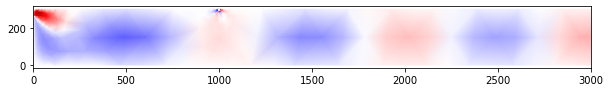

/tmp/ipykernel_3528395/3944187903.py:20: MatplotlibDeprecationWarning: Starting from Matplotlib 3.6, colorbar() will steal space from the mappable's axes, rather than from the current axes, to place the colorbar.  To silence this warning, explicitly pass the 'ax' argument to colorbar().
  plt.colorbar(cc)


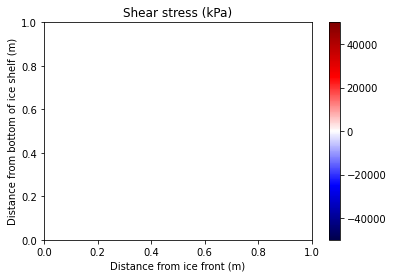

In [5]:
mats['mu'] = mats['E']/2./(1+mats['nu'])
mats['lmbda'] = mats['E']*mats['nu']/(1+mats['nu'])/(1-2*mats['nu'])

# U = U_front
U = U_all
# U = U_bottom

fig,ax=plt.subplots(figsize=(10,5))
# c=plot(sigma(U,mats['lmbda'],mats['mu'])[0,0],mode='color',vmin=00e3,vmax=300e3,cmap='viridis')
cc=plot(c.sigma(U,mats['lmbda'],mats['mu'])[0,1],mode='color',cmap='seismic',vmin=-50e3,vmax=50e3)
# cc=plot(U[0],mode='color',vmin=-10,vmax=10,cmap='seismic')

ax.set_xlim([0,3000])
# ax.set_ylim([200,300])
plt.show()

plt.xlabel('Distance from ice front (m)')
plt.ylabel('Distance from bottom of ice shelf (m)')
plt.title('Shear stress (kPa)')
plt.colorbar(cc)

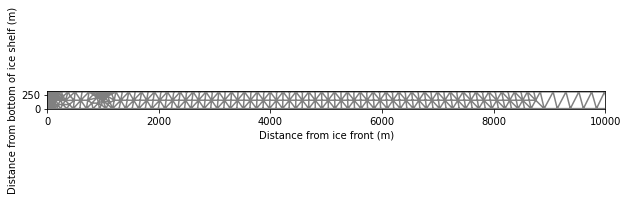

In [8]:
Hw = mats['rho']/mats['rhow']*geom['H']
fig,ax=plt.subplots(figsize=(10,5))
plot(mesh)
ax.set_xlim([0,10e3])
# ax.set_ylim([Hw-2,Hw+2])
# plt.plot(0,Hw,'or')
plt.xlabel('Distance from ice front (m)')
plt.ylabel('Distance from bottom of ice shelf (m)')
plt.show()

# Does the big variation in SIF come from the front BC or the bottom BC?
## Answer: the bottom BC

Previous result:
#### Crevasse locations: 
(10270.676691729323, 10273.182957393483)
#### SIFs:
(638801.7601736342, 602083.4188574409)
SIF Difference is -6.098547 pct over 2.506266 m



In [48]:
test_locations = (10273.182957393483,10270.676691729323)
KI=[]

for loc in test_locations:
    geom['Lc']= loc

    this_KI,this_KII = c.sif(geom,mats,verbose=False,loc='surface',swell_amplitude=1.0,
        swell_phase=3.5,swell_forcing='everything')
    
    KI.append(this_KI)

KI_front = []    
for loc in test_locations:
    geom['Lc']= loc

    this_KI,this_KII = c.sif(geom,mats,verbose=False,loc='surface',swell_amplitude=1.0,
        swell_phase=3.5,swell_forcing='front only')
    
    KI_front.append(this_KI)
    
KI_bottom = []    
for loc in test_locations:
    geom['Lc']= loc

    this_KI,this_KII = c.sif(geom,mats,verbose=False,loc='surface',swell_amplitude=1.0,
        swell_phase=3.5,swell_forcing='bottom only')
    
    KI_bottom.append(this_KI)

print(np.diff(KI)[0])
print(np.diff(KI_front)[0])
print(np.diff(KI_bottom)[0])

7869.966954740469
7869.966954740469
7869.966954740469
7869.966954740469
7869.966954740469
7869.966954740469
9902.982920081238
136.40596139698755
9900.541256906581


# Next question: is the mesh resolution fine enough within one swell wavelength of the crevasse?

In [41]:
from time import perf_counter
D, flexural_gravity_wavelength = c.fgl(mats,geom)

KI_res_test = []

resolutions = np.logspace(-2,2,10) * flexural_gravity_wavelength

for i,loc in enumerate(test_locations):
    geom['Lc']= loc
    these_KIs = []
    for res in resolutions:
        t0 = perf_counter()
        this_KI,this_KII = c.sif(geom,mats,verbose=False,loc='surface',swell_amplitude=1.0,
            swell_phase=3.5,swell_forcing='bottom only',crevasse_refinement=res)
        t1 = perf_counter()
        dt=t1-t0
        print('Resolution: %d'%res)
        print('    KI=%f'%this_KI)
        print('    dt=%f'%dt)
        these_KIs.append(this_KI)
    KI_res_test.append (these_KIs)
    print(' ')

Resolution: 78
    KI=590593.463435
    dt=6.439750
Resolution: 218
    KI=590593.463435
    dt=6.785624
Resolution: 609
    KI=590593.463435
    dt=6.714451
Resolution: 1695
    KI=597255.172164
    dt=6.499681
Resolution: 4717
    KI=602253.441739
    dt=7.114800
Resolution: 13127
    KI=615539.017555
    dt=6.755777
Resolution: 36529
    KI=615550.854456
    dt=6.685861
Resolution: 101644
    KI=615550.844522
    dt=6.532403
Resolution: 282831
    KI=615550.844522
    dt=6.625635
Resolution: 786996
    KI=615550.844522
    dt=6.543800
 
Resolution: 78
    KI=624953.094635
    dt=6.147484
Resolution: 218
    KI=624953.094635
    dt=5.747250
Resolution: 609
    KI=624953.094635
    dt=5.927312
Resolution: 1695
    KI=629979.323723
    dt=6.077494
Resolution: 4717
    KI=612177.783698
    dt=6.490071
Resolution: 13127
    KI=625439.305809
    dt=6.500351
Resolution: 36529
    KI=625451.211068
    dt=6.825711
Resolution: 101644
    KI=625451.169515
    dt=6.448451
Resolution: 282831
   

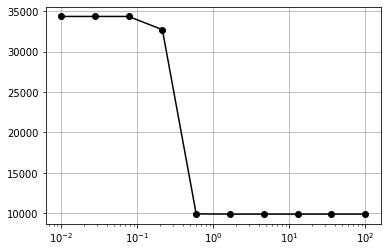

In [49]:

resolutions = np.array(resolutions)
plt.subplots()
plt.plot(resolutions/flexural_gravity_wavelength,
         np.diff(KI_res_test,axis=0).flatten(),'-ok')
plt.grid()
plt.xscale('log')
# plt.yscale('log')

# Conclusion: the previous simulations didn't have high enough resolution near the crevasse. High resolution needs to be maintained within one flexural gravity wavelength of the crevasse.